<a href="https://colab.research.google.com/github/hrithikwel8/Rossmann_Sales_Prediction/blob/main/Pradip_Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import random

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Capstone Project/Retail Sales Prediction/data/'
store_data_df = pd.read_csv(path + 'Rossmann Stores Data.csv')
store_df = pd.read_csv(path + 'store.csv')

#1. EDA

Now let's explore "Rossmann Stores Data.csv" data file.

In [ ]:
store_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


This dataset contains information about a particular day for all the stores. Date column contains information about the date on which data is collected.

This dataset contains our dependent variable 'Sales' which we need to predict.
We have information about the number of customers that visited the store on the date.

Open column gives information if the store was open or closed on the date.
We also have information about state holidays and school holidays.

Promo column contains information about a promotion offer running on a particular day. This is a special promotional offer that runs for only a given day.

In [ ]:
store_data_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


Let's find out how many stores are open and how many are closed from the dates given in the dataset.

This information gives us an idea about what is the probability of the store being open on a particular date.

Text(0.5, 0, '')

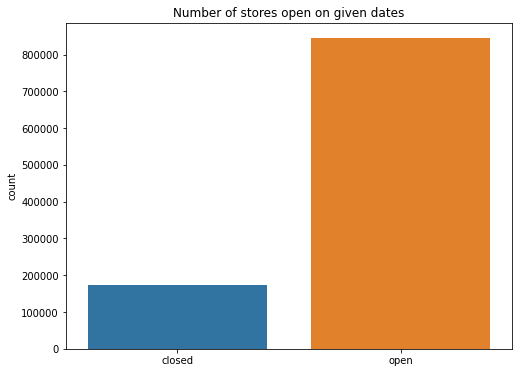

In [ ]:
# number of stores open on a given day
plt.figure(figsize=(8,6))
count = sns.countplot(x=store_data_df['Open'])
count.set_title('Number of stores open on given dates')
count.set_xticklabels(['closed', 'open'])
count.set_xlabel('')

Promotional offers attract more customers that lead to increase in sales. Let's find out how many stores run a promotional offer on given dates.

Text(0.5, 0, '')

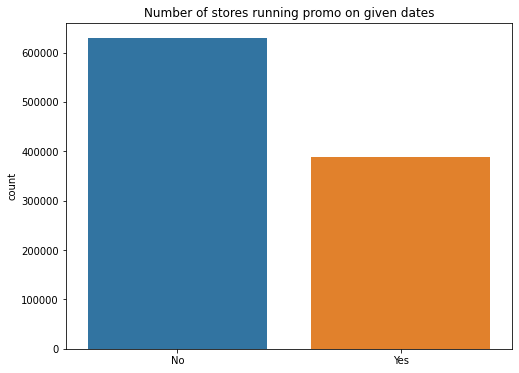

In [ ]:
# number of promo 
plt.figure(figsize=(8,6))
count = sns.countplot(x=store_data_df['Promo'])
count.set_title('Number of stores running promo on given dates')
count.set_xticklabels(['No', 'Yes'])
count.set_xlabel('')

On school holidays schools remain closed. Does this affect the Sales of stores? Let's find out the number of days schools are closed.

Text(0.5, 0, '')

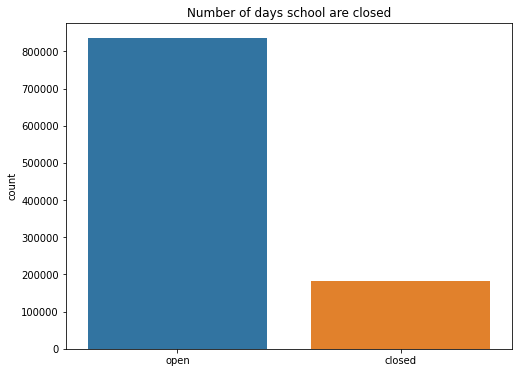

In [ ]:
# number of school holiday
plt.figure(figsize=(8,6))
count = sns.countplot(x=store_data_df['SchoolHoliday'])
count.set_title('Number of days school are closed')
count.set_xticklabels(['open', 'closed'])
count.set_xlabel('')

In [ ]:
store_data_df['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

The state holiday data is mixed data of 'string' and 'int' type of variable.

The data contains information about the type of holiday. There are 3 types of holidays, we can make 3 new features for each holiday and convert them to a binary value.

In [ ]:
# convert StateHoliday to binary value features
# 1 indicates holiday and 0 indicates no holiday
store_data_df['public_holiday'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='a' else 0)
store_data_df['easter_holiday'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='b' else 0)
store_data_df['christmas'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='c' else 0)
store_data_df.drop(columns=['StateHoliday'], inplace=True)

In [ ]:
store_data_df['public_holiday'].value_counts()

0    996949
1     20260
Name: public_holiday, dtype: int64

In [ ]:
store_data_df['easter_holiday'].value_counts()

0    1010519
1       6690
Name: easter_holiday, dtype: int64

In [ ]:
store_data_df['christmas'].value_counts()

0    1013109
1       4100
Name: christmas, dtype: int64

After getting the numbers of holidays, we can see the ratio of the holiday celebrated by stores. Let's see how many holidays are celebrated by the stores on given dates.

Text(0.5, 1.0, 'Number of Holidays celebrated by stores')

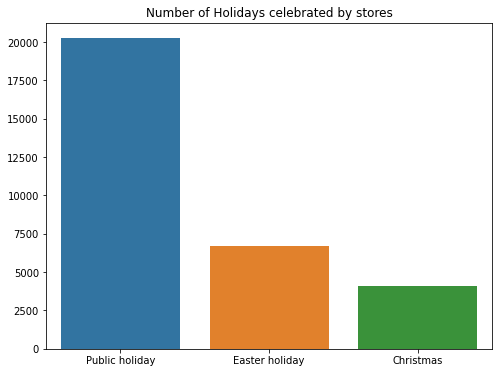

In [ ]:
# plot number of holidays present in dataset
plt.figure(figsize=(8,6))
sns.barplot(x=['Public holiday','Easter holiday','Christmas'],
            y=[store_data_df['public_holiday'].value_counts()[1],store_data_df['easter_holiday'].value_counts()[1],store_data_df['christmas'].value_counts()[1]])
plt.title('Number of Holidays celebrated by stores')

We have given information about stores being closed for refurbishment. We can assume that data for the stores that are closed for refurbishment is not present.
Let's see how many days contain information about how many store data. 

Text(0.5, 1.0, 'Number of Store data given by date')

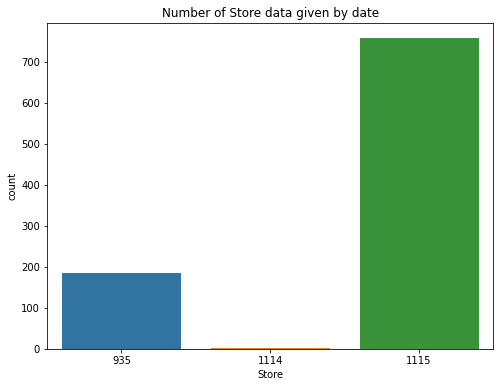

In [ ]:
# count number of stores data given by date
plt.figure(figsize=(8,6))
sns.countplot(store_data_df.groupby(['Date'])['Store'].count())
plt.title('Number of Store data given by date')

In [ ]:
store_data_df.groupby(['Date'])['Store'].count().value_counts()

1115    757
935     184
1114      1
Name: Store, dtype: int64

Data for 170 stores is not given for 184 days. 

We can assume that these stores are closed for refurbishment.

The dates are given as string we can convert them to 3 new columns 'Day, Month and Year'.

In [ ]:
# changing date from string to integer values
def get_year(date):
  year = date[:4]
  return int(year)
def get_month(date):
  month = date[5:7]
  return int(month)
def get_day(date):
  day = date[8:]
  return int(day)

In [ ]:
# create new features
store_data_df['Year'] = store_data_df['Date'].apply(lambda x: get_year(x))
store_data_df['Month'] = store_data_df['Date'].apply(lambda x: get_month(x))
store_data_df['Day'] = store_data_df['Date'].apply(lambda x: get_day(x))
# remove old Date column
store_data_df.drop(columns=['Date'], inplace=True)

In [ ]:
store_data_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31
1,2,5,6064,625,1,1,1,0,0,0,2015,7,31
2,3,5,8314,821,1,1,1,0,0,0,2015,7,31
3,4,5,13995,1498,1,1,1,0,0,0,2015,7,31
4,5,5,4822,559,1,1,1,0,0,0,2015,7,31


In [ ]:
# checking senity of data
store_open_df = store_data_df.groupby(['Open']).sum()
store_open_df

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day
Open,,,,,,,,,,,,
0,96511898,1094583,0,0,11184,18264,19566,6545,4029,348024755,1011285,2601495
1,471527846,2972565,5873180623,644041755,376896,163457,694,145,71,1700463577,4936094,13371524


We have information about holidays. But how to make it useful in Sales predictions?

We know that we don't make any sales when a store is closed.

So, if we can figure out how many stores are closed on holidays, we can use this data to calculate the probability of how many stores will be open for a given holiday.

From this probability, we can predict if the store is going to be open on a particular day or not.

In [ ]:
# calculate number of stores open on holidays
store_holiday_df = store_open_df[['SchoolHoliday', 'public_holiday', 'easter_holiday', 'christmas']].reset_index()
store_holiday_df['Open'] = store_holiday_df['Open'].apply(lambda x: 'Open' if x==1 else 'Closed')
store_holiday_df

,Open,SchoolHoliday,public_holiday,easter_holiday,christmas
0,Closed,18264,19566,6545,4029
1,Open,163457,694,145,71


In [ ]:
# melt the data frame to plot bar chart
store_holiday_df= pd.melt(store_holiday_df, id_vars =['Open'])
store_holiday_df

,Open,variable,value
0,Closed,SchoolHoliday,18264
1,Open,SchoolHoliday,163457
2,Closed,public_holiday,19566
3,Open,public_holiday,694
4,Closed,easter_holiday,6545
5,Open,easter_holiday,145
6,Closed,christmas,4029
7,Open,christmas,71


Text(0.5, 1.0, 'Number of stores open on holidays')

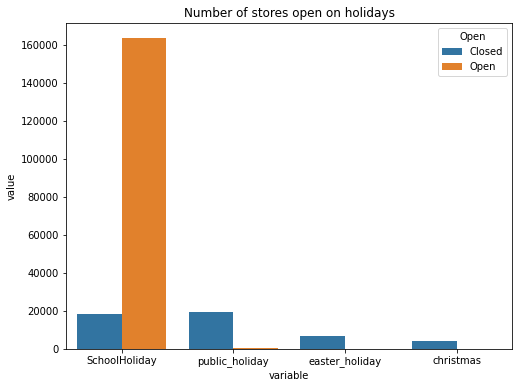

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='variable',y='value',data=store_holiday_df,hue='Open')
plt.title('Number of stores open on holidays')

For the linear regression model, we need to provide data in normal distribution to make accurate predictions. Let's plot distribution graphs.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6b3ad72d0>,
      dtype=object)

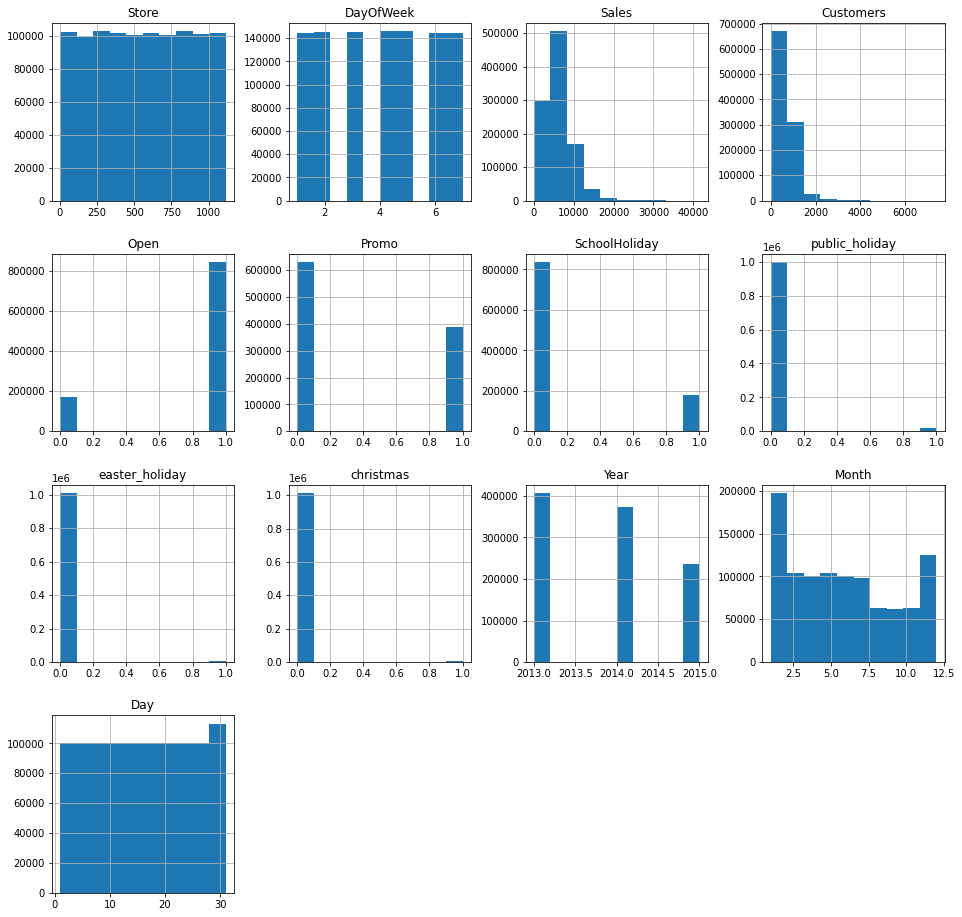

In [ ]:
# plot the distribution of values
store_data_df.hist(figsize=(16,16))

Sales and Customer data are right-skewed. We can log transform the data to remove this skewness.

In [ ]:
# Log transforming features
store_data_df['Sales_log_t'] = store_data_df['Sales'].apply(lambda x: np.log(x+1))
store_data_df['Customers_log_t'] = store_data_df['Customers'].apply(lambda x: np.log(x+1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6b196aed0>,
      dtype=object)

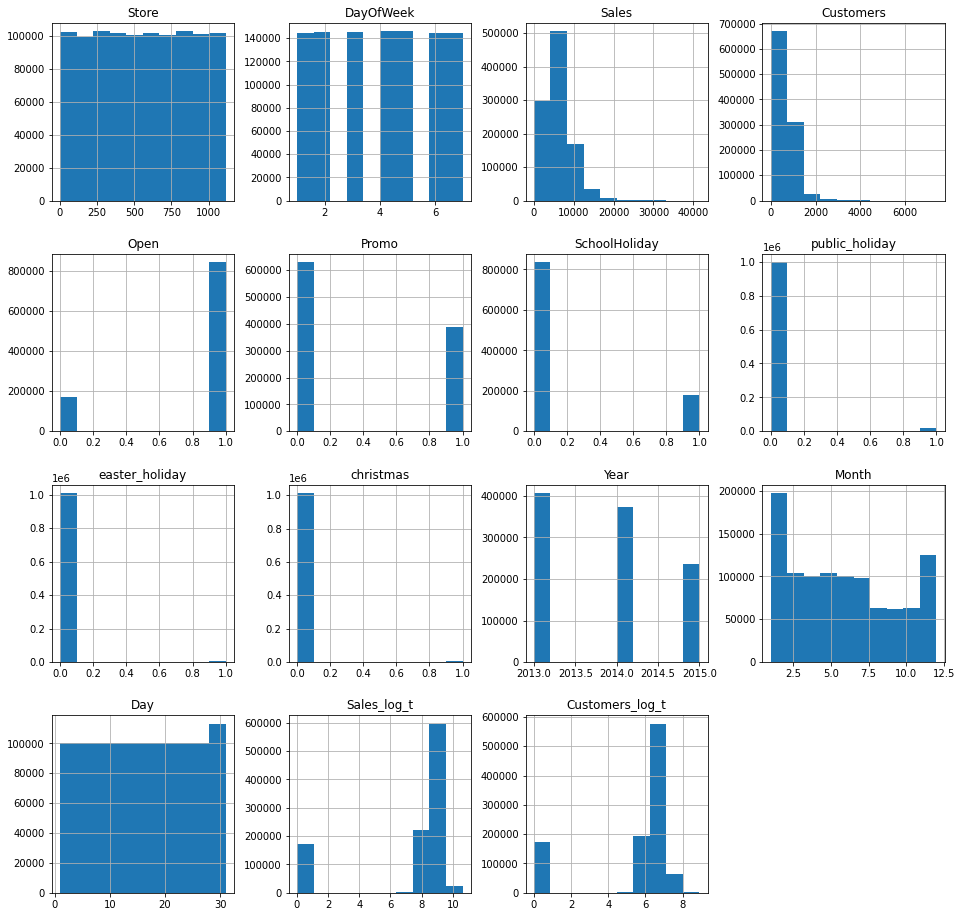

In [ ]:
store_data_df.hist(figsize=(16,16))

Let's check the relationship between sales and customer data.

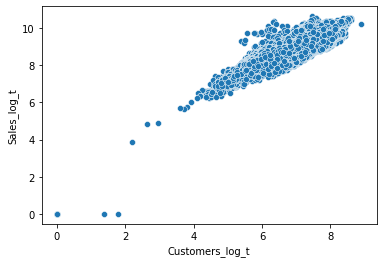

In [ ]:
# plot relation between sales and customer
sns.scatterplot(data=store_data_df,x='Customers_log_t',y='Sales_log_t')

Let's check the correlation between each variable.

Text(0.5, 1.0, 'Correlation matrix')

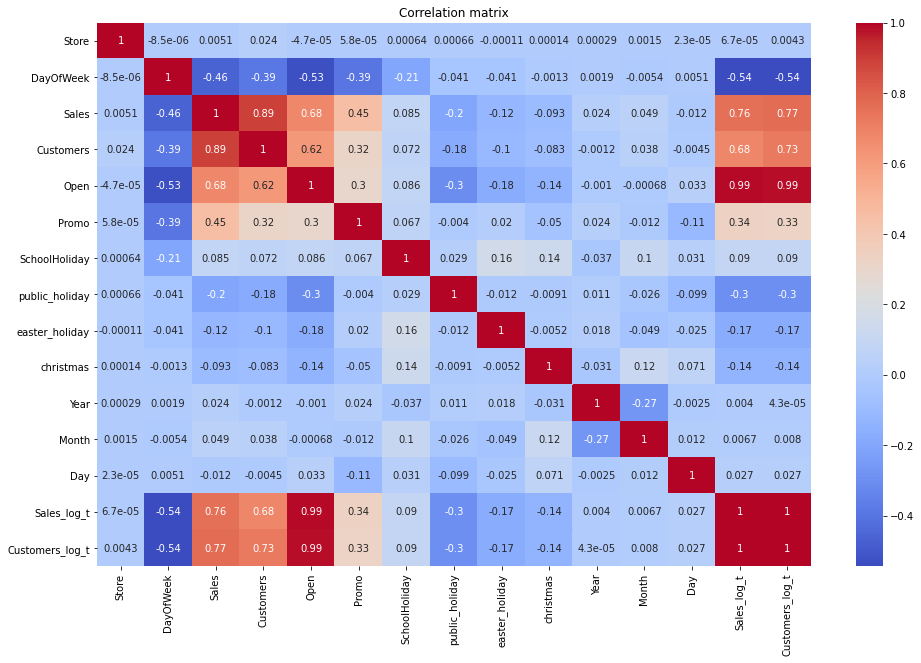

In [ ]:
# plot correlation matrix
plt.figure(figsize=(16,10))
sns.heatmap(store_data_df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation matrix')

We can see that some features have a high correlation. We need to remove this multicollinearity, but before we feed this data to our linear regression model we need to combine our datasets.

We need to merge the data based on store id to form a single dataset.

In [ ]:
# merge datasets
sales_df = pd.merge(left=store_data_df, right=store_df, on='Store')
sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,Store_Type,Assortment_Level
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
1,1,4,5020,546,1,1,1,0,0,0,2015,7,30,8.521384,6.304449,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
2,1,3,4782,523,1,1,1,0,0,0,2015,7,29,8.472823,6.261492,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
3,1,2,5011,560,1,1,1,0,0,0,2015,7,28,8.519590,6.329721,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
4,1,1,6102,612,1,1,1,0,0,0,2015,7,27,8.716536,6.418365,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1


Now that we have a dataset, we can prepare it for our model.

We have promo2 information that is a consecutive promotional offer that runs for a month at 2 months interval. But how we can use this information?

Well, we have information about the date so we can calculate if promo2 is running on the particular date. This binary value will be useful information for training our model. 

In [ ]:
# updating promo2 for given date
def continuous_promotion(data):
  promo_month = False
  # promo2 is valid for stores that participate in continuous and consecutive promotion
  if data['Promo2'] == 1:
    # promotion should be running on current month
    current_month = data['Month']
    if ((current_month % 3 == 1) and (data['PromoInterval1'] == 1)):
      promo_month = True
    if ((current_month % 3 == 2) and (data['PromoInterval2'] == 1)):
      promo_month = True
    if ((current_month % 3 == 0) and (data['PromoInterval3'] == 1)):
      promo_month = True
    # if current moth is promo month then promotion should start before current date
    if promo_month:
      if (data['Year'] > data['Promo2SinceYear']):
        # promo2 start before current year
        return 1
      if (data['Year'] == data['Promo2SinceYear']):
        # promo2 start on this year
        if (current_month > ((data['Promo2SinceWeek']//4)+1)):
          # promo2 start before current month
          return 1
  return 0

In [ ]:
# combine features for promo2
sales_df['Promo_cont'] = sales_df.apply(continuous_promotion, axis=1)

In [ ]:
# remove columns
sales_df.drop(columns=['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3'], inplace=True)

In [ ]:
sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Store_Type,Assortment_Level,Promo_cont
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,9.0,2008.0,3,1,0
1,1,4,5020,546,1,1,1,0,0,0,2015,7,30,8.521384,6.304449,1270.0,9.0,2008.0,3,1,0
2,1,3,4782,523,1,1,1,0,0,0,2015,7,29,8.472823,6.261492,1270.0,9.0,2008.0,3,1,0
3,1,2,5011,560,1,1,1,0,0,0,2015,7,28,8.519590,6.329721,1270.0,9.0,2008.0,3,1,0
4,1,1,6102,612,1,1,1,0,0,0,2015,7,27,8.716536,6.418365,1270.0,9.0,2008.0,3,1,0


We can see that there is a high correlation between some variables. We need to remove this multicollinearity.

**Removing Multicollinearity**

In [ ]:
# function to calculate VIF
def calculate_vif(data):
  vif = pd.DataFrame()
  vif["variables"] = data.columns
  vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
  return vif

In [ ]:
calculate_vif(sales_df.drop(columns=['Sales','Customers','Sales_log_t']))

,variables,VIF
0,Store,4.016097
1,DayOfWeek,8.588702
2,Open,249.549734
3,Promo,2.066414
4,SchoolHoliday,1.348287
5,public_holiday,1.235592
6,easter_holiday,1.120277
7,christmas,1.080406
8,Year,44.109260
9,Month,4.219404


We can see there are very high variation inflation factors. Let's try to remove some columns to reduce VIF.

In [ ]:
calculate_vif(sales_df.drop(columns=['Sales','Customers','Year','Sales_log_t', 'Customers_log_t']))

,variables,VIF
0,Store,3.730827
1,DayOfWeek,4.452981
2,Open,6.191915
3,Promo,1.872410
4,SchoolHoliday,1.342025
5,public_holiday,1.099311
6,easter_holiday,1.074031
7,christmas,1.072576
8,Month,3.904310
9,Day,3.965944


Now we have VIF less than 7. So, we can drop unuseful columns and start building linear regression model.